In [1]:
##########################################
#Step 0: Import libraries
##########################################
import os

import pandas as pd

from datetime import date

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns


In [2]:
##########################################
#Step 1: Import data
##########################################

In [3]:
#Setting directory

os.chdir(r'C:\Users\jlenehan\OneDrive - Intel Corporation\Documents\0 - Data Science\Intro to Data Analytics\UCDPA_JohnLenehan\UCDPA_JohnLenehan')

In [4]:
##EVICTIONS DATA
##JSON METHOD
#Set limit to 100,000 to capture all entries in json file
NY_Evictions_gross = pd.read_json(r'https://data.cityofnewyork.us/resource/6z8x-wfk4.json?$limit=100000')

##POPULATION DATA
##JSON METHOD
NY_Pop_gross=pd.read_json(r'https://data.ny.gov/resource/krt9-ym2k.json?$limit=100000')

##INCOME DATA
##CSV METHOD
#income-location data taken from datausa.io 
NY_Income_gross = pd.read_csv('Income by Location.csv')


In [5]:
##########################################
#Step 2: Describe data
##########################################

In [6]:
#Describe Evictions dataset
print(NY_Evictions_gross.columns)
print(NY_Evictions_gross.info())
print(NY_Evictions_gross.describe())
print(NY_Evictions_gross.shape)

print(NY_Evictions_gross.head())

print('\nNY Evictions Data - Unique Values:')
for x in NY_Evictions_gross.columns:
    print(x+':')
    print(NY_Evictions_gross[x].unique())
    print(str(NY_Evictions_gross[x].nunique()) + str(' unique values'))

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apt_num', 'executed_date', 'marshal_first_name',
       'marshal_last_name', 'residential_commercial_ind', 'borough',
       'eviction_zip', 'ejectment', 'eviction_possession', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bin', 'bbl', 'nta'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70319 entries, 0 to 70318
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   court_index_number          70319 non-null  object 
 1   docket_number               70319 non-null  int64  
 2   eviction_address            70319 non-null  object 
 3   eviction_apt_num            58577 non-null  object 
 4   executed_date               70319 non-null  object 
 5   marshal_first_name          70319 non-null  object 
 6   marshal_last_name           7031

51 unique values
census_tract:
[  110. 99802.   552. ...  1129.   669.  1097.]
1293 unique values
bin:
[1044388. 4595352. 3182470. ... 1017796. 5027246. 3126163.]
31771 unique values
bbl:
[1.01438750e+09 4.15817750e+09 3.06780004e+09 ... 1.00871003e+09
 5.01194011e+09 3.05374004e+09]
29752 unique values
nta:
['Lenox Hill-Roosevelt Island' 'Far Rockaway-Bayswater' 'Madison'
 'West Concourse' nan 'West New Brighton-New Brighton-St. George'
 'Crown Heights North' 'East New York' 'Manhattanville' 'Clinton Hill'
 'Mount Hope' 'Queens Village' 'Williamsbridge-Olinville' 'Fordham South'
 'Astoria' 'Central Harlem North-Polo Grounds' 'Bensonhurst East'
 'Longwood' 'Pelham Parkway' 'Erasmus' 'Canarsie' 'West Farms-Bronx River'
 'Hammels-Arverne-Edgemere' 'Belmont' 'Glendale' 'Elmhurst'
 'Middle Village' 'Brownsville' 'Mott Haven-Port Morris'
 'University Heights-Morris Heights' 'Claremont-Bathgate' 'Flushing'
 'Bedford' 'Crotona Park East' 'East Flatbush-Farragut'
 'East Harlem North' 'Crown He

In [7]:
#Describe Income dataset
print(NY_Income_gross.columns)
print(NY_Income_gross.info())
print(NY_Income_gross.describe())
print(NY_Income_gross.shape)

print(NY_Income_gross.head())

print('\nNY Income Data - Unique Values:')
for x in NY_Income_gross.columns:
    print(x+':')
    print(NY_Income_gross[x].unique())
    print(str(NY_Income_gross[x].nunique()) + str(' unique values'))

Index(['ID Year', 'Year', 'ID Race', 'Race', 'Household Income by Race',
       'Household Income by Race Moe', 'Geography', 'ID Geography'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16693 entries, 0 to 16692
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID Year                       16693 non-null  int64  
 1   Year                          16693 non-null  int64  
 2   ID Race                       16693 non-null  int64  
 3   Race                          16693 non-null  object 
 4   Household Income by Race      16693 non-null  int64  
 5   Household Income by Race Moe  16669 non-null  float64
 6   Geography                     16693 non-null  object 
 7   ID Geography                  16693 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 1.0+ MB
None
            ID Year          Year  ID Race  Household Income by Race  \

In [8]:
#Describe Population dataset
print(NY_Pop_gross.columns)
print(NY_Pop_gross.info())
print(NY_Pop_gross.describe())
print(NY_Pop_gross.shape)

print(NY_Pop_gross.head())

print('\nNY Population Data - Unique Values:')
for x in NY_Pop_gross.columns:
    print(x+':')
    print(NY_Pop_gross[x].unique())
    print(str(NY_Pop_gross[x].nunique()) + str(' unique values'))

Index(['fips_code', 'geography', 'year', 'program_type', 'population'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   fips_code     3654 non-null   int64 
 1   geography     3654 non-null   object
 2   year          3654 non-null   int64 
 3   program_type  3654 non-null   object
 4   population    3654 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 142.9+ KB
None
          fips_code         year    population
count   3654.000000  3654.000000  3.654000e+03
mean   36061.015873  1995.448276  5.922912e+05
std       36.346603    15.238354  2.351561e+06
min    36000.000000  1970.000000  4.438000e+03
25%    36029.000000  1982.000000  5.150125e+04
50%    36061.000000  1995.500000  8.831400e+04
75%    36093.000000  2009.000000  2.523632e+05
max    36123.000000  2021.000000  2.020125e+07
(3654, 5)
   fips_code        ge

In [9]:
##########################################
#Step 3: Clean + Manipulate data
##########################################

In [10]:
##Cleaning NY Evictions Data

#Adding year info
NY_Evictions_gross['executed_date']=pd.to_datetime(NY_Evictions_gross['executed_date'])
NY_Evictions_gross['year']=pd.DatetimeIndex(NY_Evictions_gross['executed_date']).year

#sanity check
print(NY_Evictions_gross.head())

#grouping evictions by year and borough
NY_Evictions = NY_Evictions_gross.groupby(['year','borough'], sort = [True,True])['eviction_zip'].count()

#resetting index on pivot table
NY_Evictions = NY_Evictions.reset_index()

#renaming column to sum_evictions
NY_Evictions.rename(columns = {'eviction_zip':'sum_evictions'}, inplace=True)

#print final dataset
print(NY_Evictions)

  court_index_number  docket_number      eviction_address eviction_apt_num  \
0           52841/17           8271  300 EAST 64TH STREET              5-I   
1           72193/17          13665   120 BEACH 26 STREET             1501   
2          88688/16B          57195     1719 QUENTIN ROAD               5C   
3         B043281/19         408391  50 EAST 172ND STREET               2W   
4           68326/19          19697         94-06 34 ROAD               B1   

  executed_date marshal_first_name marshal_last_name  \
0    2017-10-03             George       Essock, Jr.   
1    2018-01-08             Edward             Guida   
2    2017-03-17             Justin          Grossman   
3    2020-01-08            Richard             McCoy   
4    2019-12-20             George       Essock, Jr.   

  residential_commercial_ind    borough  eviction_zip  ...  \
0                Residential  MANHATTAN         10065  ...   
1                Residential     QUEENS         11691  ...   
2       

In [11]:
##Cleaning NY Income data

#if statement to avoid duplicates on reruns
if 'Borough' not in NY_Income_gross.columns:
    
    #splitting geography column by ',' delimiter to get county column
    NY_Income_geodata = NY_Income_gross.Geography.str.split(',',expand=True)
    
    #merging new columns to income table by index
    NY_Income_gross = NY_Income_gross.merge(NY_Income_geodata, 
                                        left_index=True, 
                                        right_index=True,
                                        how='inner')

#Renaming columns
NY_Income_gross.rename(columns = {'Household Income by Race':'Household Income',
                                  'Household Income by Race Moe':'Household Income MOE',
                                  0:'Census Tract',1:'Borough',2:'State'},
                       inplace=True)

#Adjusting borough data to match evictions borough data format
NY_Income_gross['Borough']=NY_Income_gross['Borough'].replace([' Bronx County',
                                                               ' Kings County',
                                                               ' New York County',
                                                               ' Queens County',
                                                               ' Richmond County'],
                                  ['BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND'])

#sanity check
print(NY_Income_gross.head())

#filtering relevant columns for analysis
NY_Income_gross = NY_Income_gross[['Borough','Year','Household Income','Household Income MOE']]

#getting mean household income and margin of error by year and borough
NY_Income = NY_Income_gross.groupby(['Year','Borough'],
                                    sort = [True,True])['Household Income','Household Income MOE'].mean()

#rounding values to 2 decimal places
NY_Income = NY_Income.round(decimals=2)

#resetting index
NY_Income = NY_Income.reset_index()

#print final dataset
print(NY_Income)


   ID Year  Year  ID Race   Race  Household Income  Household Income MOE  \
0     2020  2020        0  Total             68000               21984.0   
1     2020  2020        0  Total             93155               12263.0   
2     2020  2020        0  Total             34766                6118.0   
3     2020  2020        0  Total             24474                7684.0   
4     2020  2020        0  Total             27196                8483.0   

                           Geography        ID Geography     Census Tract  \
0   Census Tract 2, Bronx County, NY  14000US36005000200   Census Tract 2   
1   Census Tract 4, Bronx County, NY  14000US36005000400   Census Tract 4   
2  Census Tract 16, Bronx County, NY  14000US36005001600  Census Tract 16   
3  Census Tract 23, Bronx County, NY  14000US36005002300  Census Tract 23   
4  Census Tract 25, Bronx County, NY  14000US36005002500  Census Tract 25   

  Borough State  
0   BRONX    NY  
1   BRONX    NY  
2   BRONX    NY  
3   BRON

C:\Users\jlenehan\AppData\Local\Temp\ipykernel_5156\169235047.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  NY_Income = NY_Income_gross.groupby(['Year','Borough'],


In [12]:
##Cleaning NY Pop data

#filtering data to only see census data from 2020, and ignore population estimates
NY_Pop_gross = NY_Pop_gross[(NY_Pop_gross['program_type']=='Census Base Population') & (NY_Pop_gross['year']==2020)]


if 'geography' in NY_Pop_gross.columns:
    
    #filtering to 5 boroughs (counties) of New York city
    NY_Pop_gross = NY_Pop_gross.loc[NY_Pop_gross['geography'].isin(['Bronx County',
                                                                    'Kings County',
                                                                    'New York County',
                                                                    'Queens County',
                                                                    'Richmond County'])]

    #Adjusting borough data to match evictions borough data format
    NY_Pop_gross['geography']=NY_Pop_gross['geography'].replace(['Bronx County',
                                                                 'Kings County',
                                                                 'New York County',
                                                                 'Queens County',
                                                                 'Richmond County'],
                                  ['BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND']) 

    #renaming geography column to borough
    NY_Pop_gross.rename(columns = {'geography':'borough'}, inplace=True)

#sanity check
print(NY_Pop_gross)

NY_Pop = NY_Pop_gross[['borough','year','population']]

NY_Pop.set_index('borough',inplace=True)

print(NY_Pop)


     fips_code        borough  year            program_type  population
129      36005          BRONX  2020  Census Base Population     1472654
150      36047       BROOKLYN  2020  Census Base Population     2736074
157      36061      MANHATTAN  2020  Census Base Population     1694251
167      36081         QUEENS  2020  Census Base Population     2405464
169      36085  STATEN ISLAND  2020  Census Base Population      495747
               year  population
borough                        
BRONX          2020     1472654
BROOKLYN       2020     2736074
MANHATTAN      2020     1694251
QUEENS         2020     2405464
STATEN ISLAND  2020      495747


In [13]:
##########################################
#Step 4: Joining data
##########################################

In [14]:
##Joining income data to population data - left join
##2020 census populations will be taken as the 

NY_Income_Pop = NY_Income.merge(NY_Pop['population'], how = 'left',
                                    left_on = 'Borough', right_on = 'borough')

print(NY_Income_Pop)


    Year        Borough  Household Income  Household Income MOE  population
0   2013          BRONX          39525.86              10160.88     1472654
1   2013       BROOKLYN          52152.55              12350.03     2736074
2   2013      MANHATTAN          79878.71              18840.48     1694251
3   2013         QUEENS          61378.72              14376.66     2405464
4   2013  STATEN ISLAND          72802.25              13725.81      495747
5   2014          BRONX          39249.36              10488.69     1472654
6   2014       BROOKLYN          53130.10              12067.54     2736074
7   2014      MANHATTAN          82404.63              19210.25     1694251
8   2014         QUEENS          61879.28              13986.73     2405464
9   2014  STATEN ISLAND          74558.15              14167.82      495747
10  2015          BRONX          39311.20               8547.60     1472654
11  2015       BROOKLYN          54264.91              11949.44     2736074
12  2015    

In [15]:
##Joining datasets (NY_Merged dataframe)

##Joining eviction data to income-population data - left join
##2020 borough census populations will be taken as the same for all years 

NY_Merged = NY_Evictions.merge(NY_Income_Pop, how = 'left',
                               left_on = ['year','borough'], 
                               right_on = ['Year','Borough'])

#dropping missing values
NY_Merged.dropna(inplace=True)

#filtering out redundant columns
NY_Merged = NY_Merged[['year','borough','sum_evictions','Household Income','Household Income MOE','population']]

#Renaming columns
NY_Merged.rename(columns = {'year':'Year',
                            'borough':'Borough',
                            'sum_evictions':'Sum Evictions',
                            'population':'Population'}, 
                 inplace=True)

#Changing Year column to string
NY_Merged['Year']=NY_Merged['Year'].apply(str)

#printing final dataset
print(NY_Merged)


    Year        Borough  Sum Evictions  Household Income  \
0   2017          BRONX           7658          41688.32   
1   2017       BROOKLYN           6355          59774.86   
2   2017      MANHATTAN           3450          91715.70   
3   2017         QUEENS           4325          66931.36   
4   2017  STATEN ISLAND            734          75298.24   
5   2018          BRONX           7140          43354.89   
6   2018       BROOKLYN           6157          63340.91   
7   2018      MANHATTAN           3390          94790.56   
8   2018         QUEENS           4452          70348.20   
9   2018  STATEN ISLAND            691          78057.55   
10  2019          BRONX           6244          45628.97   
11  2019       BROOKLYN           5312          67743.39   
12  2019      MANHATTAN           2818          99467.44   
13  2019         QUEENS           3705          73779.56   
14  2019  STATEN ISLAND            636          82968.25   
15  2020          BRONX           1088  

In [16]:
##Adding computed columns to merged dataset

#Evictions per 1,000 people
NY_Merged['Evictions per 1,000'] = 1000*(NY_Merged['Sum Evictions']/NY_Merged['Population'])

#Upper margin of Household Income
NY_Merged['Household Income - Upper Margin'] = NY_Merged['Household Income']+NY_Merged['Household Income MOE'] 

#Lower margin of Household Income
NY_Merged['Household Income - Lower Margin'] = NY_Merged['Household Income']-NY_Merged['Household Income MOE'] 

#sanity check
print(NY_Merged.head())

   Year        Borough  Sum Evictions  Household Income  Household Income MOE  \
0  2017          BRONX           7658          41688.32               9209.21   
1  2017       BROOKLYN           6355          59774.86              12981.86   
2  2017      MANHATTAN           3450          91715.70              19810.96   
3  2017         QUEENS           4325          66931.36              13756.62   
4  2017  STATEN ISLAND            734          75298.24              14432.01   

   Population  Evictions per 1,000  Household Income - Upper Margin  \
0   1472654.0             5.200135                         50897.53   
1   2736074.0             2.322671                         72756.72   
2   1694251.0             2.036298                        111526.66   
3   2405464.0             1.797990                         80687.98   
4    495747.0             1.480594                         89730.25   

   Household Income - Lower Margin  
0                         32479.11  
1           

In [17]:
#show correlations in dataset
NY_Merged.corr()

,Sum Evictions,Household Income,Household Income MOE,Population,"Evictions per 1,000",Household Income - Upper Margin,Household Income - Lower Margin
Sum Evictions,1.000000,-0.620283,-0.708677,0.441593,0.864418,-0.645123,-0.574023
Household Income,-0.620283,1.000000,0.926916,-0.155193,-0.648283,0.997217,0.993048
Household Income MOE,-0.708677,0.926916,1.000000,-0.142458,-0.733238,0.952313,0.876298
Population,0.441593,-0.155193,-0.142458,1.000000,-0.001535,-0.154484,-0.154551
"Evictions per 1,000",0.864418,-0.648283,-0.733238,-0.001535,1.000000,-0.672769,-0.602266
Household Income - Upper Margin,-0.645123,0.997217,0.952313,-0.154484,-0.672769,1.000000,0.981508
Household Income - Lower Margin,-0.574023,0.993048,0.876298,-0.154551,-0.602266,0.981508,1.000000


In [18]:
##########################################
#Step 5: Plot data
##########################################

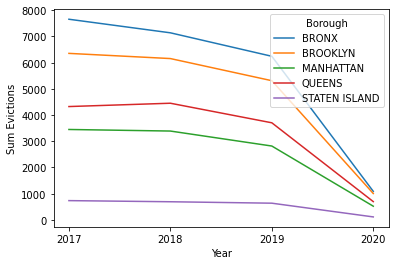

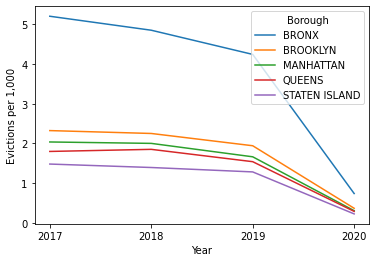

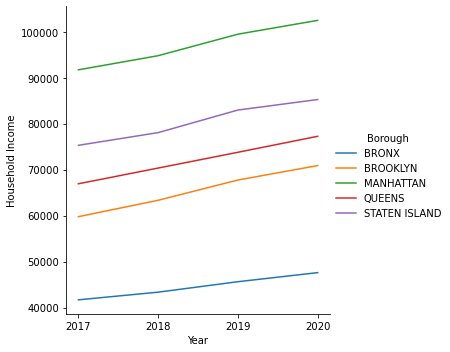

In [19]:
#Get evictions by borough, year
sns.lineplot(x=NY_Merged['Year'],y=NY_Merged['Sum Evictions'],hue=NY_Merged['Borough'])
plt.show()

#Show evictions per 1000 by borough, year
sns.lineplot(x=NY_Merged['Year'],y=NY_Merged['Evictions per 1,000'],hue=NY_Merged['Borough'])
plt.show()

#Show mean household income by borough, year
sns.relplot(x=NY_Merged['Year'],y=NY_Merged['Household Income'], kind='line',hue=NY_Merged['Borough'])
plt.show()


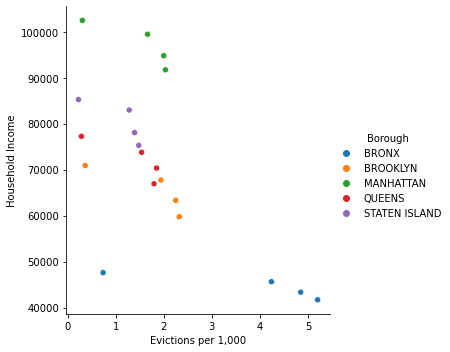

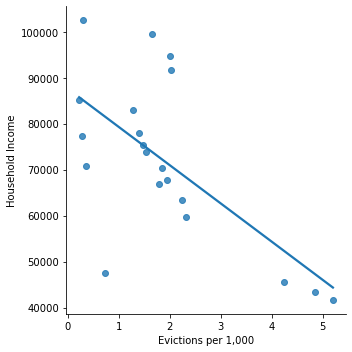

                     Evictions per 1,000  Household Income
Evictions per 1,000             1.000000         -0.648283
Household Income               -0.648283          1.000000


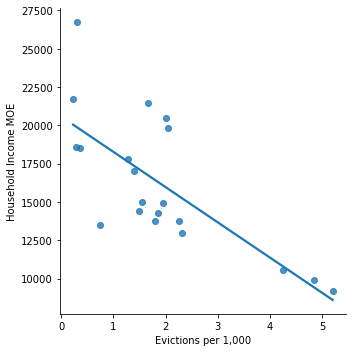

                      Evictions per 1,000  Household Income MOE
Evictions per 1,000              1.000000             -0.733238
Household Income MOE            -0.733238              1.000000


In [20]:
#Show evictions per 1,000 against household income
sns.relplot(x='Evictions per 1,000',
            y='Household Income',
            hue='Borough',
            data=NY_Merged)

plt.show()

#define function for getting scatter plot of 2 variables and printing correlation coefficient
def plot_correlation(df,var1,var2,group=None):
    sns.lmplot(x=var1,y=var2,hue=group,data=df,ci=0)
    plt.show()
    
    print(df[[var1,var2]].corr())
    
    return 

#get scatter of evictions per 1,000 vs mean household income
plot_correlation(NY_Merged,'Evictions per 1,000','Household Income')

#get scatter of evictions per 1,000 vs mean household income MOE
plot_correlation(NY_Merged,'Evictions per 1,000','Household Income MOE')
